 <h1 style="text-align: center; font-size: 50px;font-weight: bold;"> Bayesian Machine Learning
   </h1>


 <h1 style="text-align: center; font-size: 25px;font-weight: bold;"> Project : Computing Nonvacuous Generalization Bounds for Deep (Stochastic) Neural
 Networks with Many More Parameters than Training Data </h1>


In [1]:
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.init as init
import numpy as np

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
# Download and load the dataset
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_dataset = torch.utils.data.Subset(train_dataset, range(55000))
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

In [3]:
print(train_dataset)
print(test_dataset)

Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )


In [4]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=100, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100, shuffle=False)

# Get a batch of images and labels
images, labels = next(iter(train_loader))

In [5]:
print(images.shape, labels.shape)

torch.Size([100, 1, 28, 28]) torch.Size([100])


tensor(-0.2367) tensor(2.8215) tensor(-0.4242)


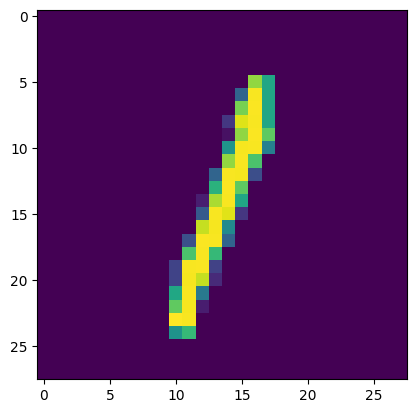

In [6]:
plt.imshow(images[0,0,:,:])
print(torch.mean(images[0,0,:,:]), torch.max(images[0,0,:,:]), torch.min(images[0,0,:,:]))

In [7]:
class MLP(nn.Module):
    def __init__(self, nb_nodes, nb_hidden_layers, classes=1):
        super().__init__()

        layers = [nn.Linear(28 * 28, nb_nodes), nn.ReLU()]

        for _ in range(nb_hidden_layers - 1):
            layers.append(nn.Linear(nb_nodes, nb_nodes))
            layers.append(nn.ReLU())
            # layers.append(nn.Dropout(p=0.4))

        layers.append(nn.Linear(nb_nodes, classes))

        self.layers = nn.Sequential(*layers)

        self.initialize_weights()   # Initialize weights after layer creation

    def forward(self, input):
        x = torch.flatten(input, start_dim=1)
        x = self.layers(x)
        return x

    def truncated_normal_(self, tensor, mean=0, std=0.04, low=-2, high=2):
        """Truncated normal initialization for weights."""
        with torch.no_grad():
            tensor.normal_(mean, std)
            tensor.clamp_(low*std, high*std)  # Truncate values to [-2*sigma, 2*sigma]

    def initialize_weights(self):
        """Initialize weights and biases as per the given specifications."""
        linear_layer = 0
        for  m in self.modules():
            if isinstance(m, nn.Linear):
                self.truncated_normal_(m.weight, mean=0, std=0.04, low=-2, high=2)
                
                if linear_layer == 0:  # First layer after input
                    init.constant_(m.bias, 0.1)
                else:
                    init.constant_(m.bias, 0)
                linear_layer +=1

In [8]:
lr = 0.0001
epochs = 200
patience = 20

In [9]:
import copy
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# model = MLP(nb_nodes=600, nb_hidden_layers=2).to(device)
model = MLP(nb_nodes=600, nb_hidden_layers=1)
print(model)

# optimizer = torch.optim.RMSprop(model.parameters(), lr = lr, momentum=0.9, eps=1e-5)
# optimizer = torch.optim.Adam(model.parameters(), lr = lr)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

MLP(
  (layers): Sequential(
    (0): Linear(in_features=784, out_features=600, bias=True)
    (1): ReLU()
    (2): Linear(in_features=600, out_features=1, bias=True)
  )
)


In [10]:
def print_weights_and_biases(model):
    for name, param in model.named_parameters():
        if "weight" in name:
            print(f"Layer: {name} | Weights:\n{param.data}\n")
        elif "bias" in name:
            print(f"Layer: {name} | Biases:\n{param.data}\n")

# print_weights_and_biases(model)


In [ ]:
import torch.nn.functional as F

def plot_training_history(history_train_loss, history_val_loss):
    epochs = range(1, len(history_train_loss) + 1)

    # figure avec deux sous-graphes côte à côte
    plt.figure(figsize=(14, 5))

    # Graphique pour la perte
    plt.semilogy(epochs, history_train_loss, label='Train Loss', marker='o')
    plt.semilogy(epochs, history_val_loss, label='Validation Loss', marker='o')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

def label_modif(label):
    """ Changes the labels of the MNIST dataset to transform it into a binary
    classification problem by mapping numbers {0,.....,4} to label 1 and {5,......,9} to label -1"""
    # print("label check before", label)
    label[label<=4] = 1
    label[label >=5] = -1
    # print("label check after", label)
    
    return label

# Logistic (surrogate) loss: defined as (1/log2)*log(1+exp(-y * output))
def logistic_loss(outputs, targets):
    # targets assumed to be in {-1, +1}
    return torch.mean((1.0 / np.log(2)) * F.softplus(-targets * outputs))


def logistic_loss(labels, outputs):
    loss = (1/(np.log(2)))*torch.log(1+torch.exp(-labels*outputs))
    return torch.mean(loss)


def training_pipeline(epochs, model, train_loader, test_loader, optimizer, patience):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    loss_train_tab = []
    loss_valid_tab = []
    best_val_loss = float("inf")
    best_model = None
    model.to(device)
    print("Module sélectionné pour l'entraînement :", device)
    epochs_no_improve = 0
    
    for epoch in range(epochs):
        model.train()
        total_train_loss = 0.0
        total_train_correct = 0
        total_train_samples = 0
        
        for k, (image_train, label_train) in enumerate(train_loader):
            label_train = label_modif(label_train)
            image_train, label_train = image_train.to(device), label_train.to(device).float()
            optimizer.zero_grad()
            output = model(image_train)
            loss = logistic_loss(label_train, output.squeeze(1))
            loss.backward()
            optimizer.step()
            
            total_train_loss += loss.item()
            # Prediction: sign of output as predicted label (assumes output is a real number)
            predictions = torch.sign(output.squeeze(1))
            total_train_correct += (predictions == label_train).sum().item()
            total_train_samples += label_train.size(0)
        
        avg_train_loss = total_train_loss / len(train_loader)
        train_accuracy = total_train_correct / total_train_samples
        loss_train_tab.append(avg_train_loss)
        
        model.eval()
        total_val_loss = 0.0
        total_val_correct = 0
        total_val_samples = 0
        with torch.no_grad():
            for k, (image_test, label_test) in enumerate(test_loader):
                label_test = label_modif(label_test)
                image_test, label_test = image_test.to(device), label_test.to(device).float()
                output = model(image_test)
                loss = logistic_loss(label_test, output.squeeze(1))
                total_val_loss += loss.item()
                predictions = torch.sign(output.squeeze(1))
                total_val_correct += (predictions == label_test).sum().item()
                total_val_samples += label_test.size(0)
        avg_val_loss = total_val_loss / len(test_loader)
        val_accuracy = total_val_correct / total_val_samples
        loss_valid_tab.append(avg_val_loss)
        
        print(f"Epoch {epoch + 1}/{epochs} - Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}")
        
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model = copy.deepcopy(model)  # Sauvegarde du meilleur modèle
            epochs_no_improve = 0  # Reset du compteur
            print(f"A new best model has been found with validation loss: {best_val_loss:.4f}")
        else:
            epochs_no_improve += 1
        
        if epochs_no_improve >= patience:
            print(f"Early stopping triggered after {patience} epochs with no improvement.")
            break
        
        if (epoch + 1) % 10 == 0:
            plot_training_history(loss_train_tab, loss_valid_tab)
            
    plot_training_history(loss_train_tab, loss_valid_tab)
    return best_model, loss_valid_tab

        

Module sélectionné pour l'entraînement : cuda
Epoch 1/20 - Train Loss: 0.2234, Validation Loss: 0.1264, Train Acc: 0.9409, Val Acc: 0.9691
A new best model has been found with validation loss: 0.1264
Epoch 2/20 - Train Loss: 0.1028, Validation Loss: 0.1148, Train Acc: 0.9756, Val Acc: 0.9737
A new best model has been found with validation loss: 0.1148
Epoch 3/20 - Train Loss: 0.0766, Validation Loss: 0.1012, Train Acc: 0.9813, Val Acc: 0.9748
A new best model has been found with validation loss: 0.1012
Epoch 4/20 - Train Loss: 0.0566, Validation Loss: 0.0886, Train Acc: 0.9868, Val Acc: 0.9789
A new best model has been found with validation loss: 0.0886
Epoch 5/20 - Train Loss: 0.0445, Validation Loss: 0.0948, Train Acc: 0.9897, Val Acc: 0.9766
Epoch 6/20 - Train Loss: 0.0337, Validation Loss: 0.0890, Train Acc: 0.9931, Val Acc: 0.9802
Epoch 7/20 - Train Loss: 0.0260, Validation Loss: 0.0846, Train Acc: 0.9948, Val Acc: 0.9821
A new best model has been found with validation loss: 0.084

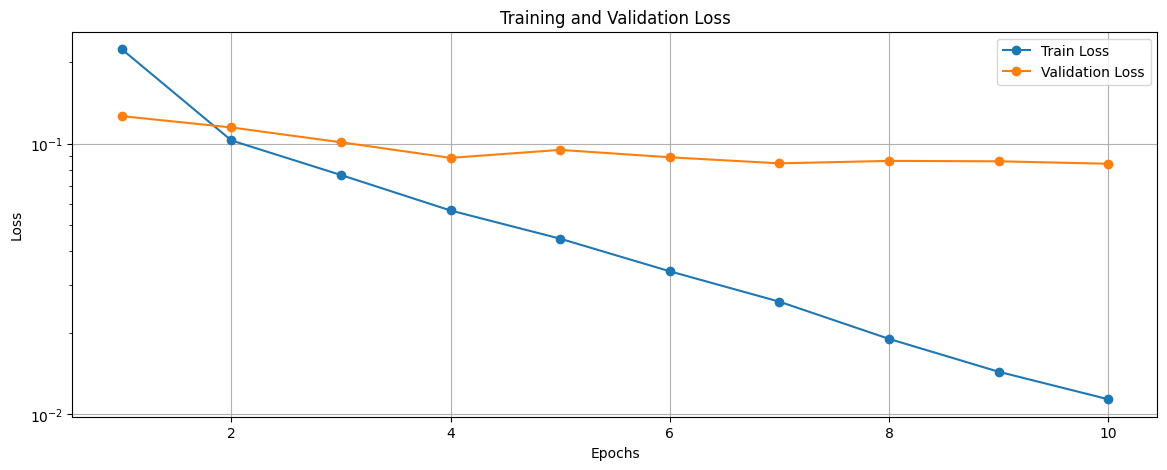

Epoch 11/20 - Train Loss: 0.0085, Validation Loss: 0.0872, Train Acc: 0.9993, Val Acc: 0.9822
Epoch 12/20 - Train Loss: 0.0066, Validation Loss: 0.0886, Train Acc: 0.9996, Val Acc: 0.9823
Epoch 13/20 - Train Loss: 0.0051, Validation Loss: 0.0875, Train Acc: 0.9998, Val Acc: 0.9821
Epoch 14/20 - Train Loss: 0.0041, Validation Loss: 0.0901, Train Acc: 0.9999, Val Acc: 0.9824
Epoch 15/20 - Train Loss: 0.0034, Validation Loss: 0.0915, Train Acc: 1.0000, Val Acc: 0.9813
Epoch 16/20 - Train Loss: 0.0029, Validation Loss: 0.0921, Train Acc: 1.0000, Val Acc: 0.9819
Epoch 17/20 - Train Loss: 0.0026, Validation Loss: 0.0929, Train Acc: 1.0000, Val Acc: 0.9825
Epoch 18/20 - Train Loss: 0.0024, Validation Loss: 0.0939, Train Acc: 0.9999, Val Acc: 0.9834
Epoch 19/20 - Train Loss: 0.0021, Validation Loss: 0.0944, Train Acc: 1.0000, Val Acc: 0.9824
Epoch 20/20 - Train Loss: 0.0019, Validation Loss: 0.0956, Train Acc: 1.0000, Val Acc: 0.9831


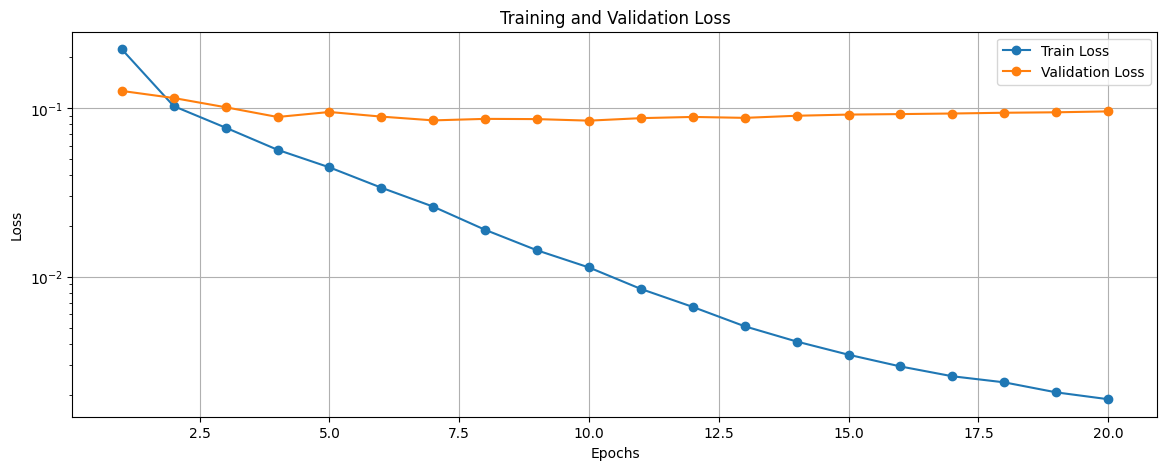

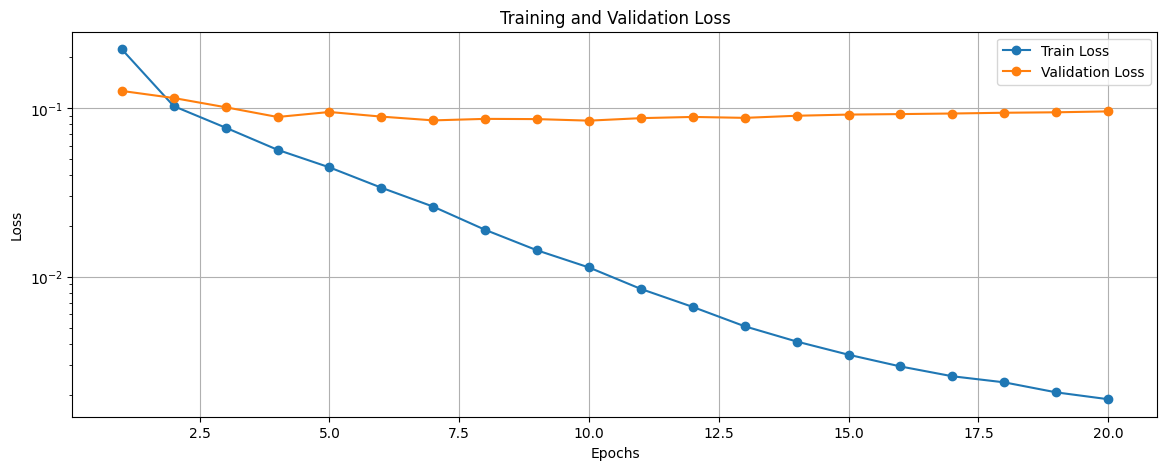

In [17]:
best_model, loss_validation = training_pipeline(epochs=20, model=model, train_loader=train_loader, test_loader=test_loader, optimizer=optimizer, patience=patience)

Module sélectionné pour l'entraînement :  cuda
Epoch 1/20 - Train Loss: 0.2229, Validation Loss: 0.1224
A new best model has been found with validation loss: 0.1224
Epoch 2/20 - Train Loss: 0.0999, Validation Loss: 0.1106
A new best model has been found with validation loss: 0.1106
Epoch 3/20 - Train Loss: 0.0727, Validation Loss: 0.0840
A new best model has been found with validation loss: 0.0840
Epoch 4/20 - Train Loss: 0.0556, Validation Loss: 0.0794
A new best model has been found with validation loss: 0.0794
Epoch 5/20 - Train Loss: 0.0437, Validation Loss: 0.0885
Epoch 6/20 - Train Loss: 0.0354, Validation Loss: 0.0716
A new best model has been found with validation loss: 0.0716
Epoch 7/20 - Train Loss: 0.0263, Validation Loss: 0.0744
Epoch 8/20 - Train Loss: 0.0211, Validation Loss: 0.0729
Epoch 9/20 - Train Loss: 0.0158, Validation Loss: 0.0742
Epoch 10/20 - Train Loss: 0.0123, Validation Loss: 0.0759


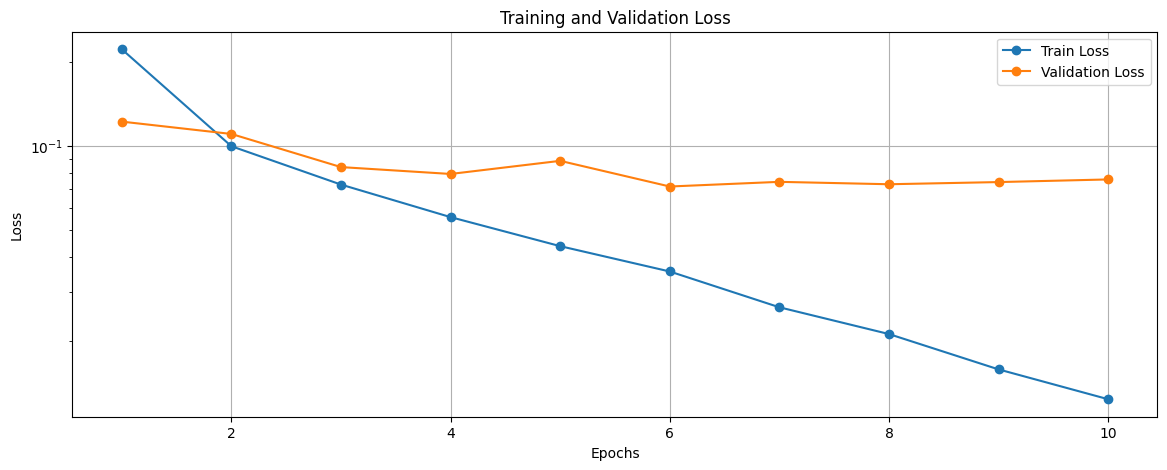

Epoch 11/20 - Train Loss: 0.0093, Validation Loss: 0.0778
Epoch 12/20 - Train Loss: 0.0080, Validation Loss: 0.0748
Epoch 13/20 - Train Loss: 0.0056, Validation Loss: 0.0753
Epoch 14/20 - Train Loss: 0.0045, Validation Loss: 0.0804
Epoch 15/20 - Train Loss: 0.0039, Validation Loss: 0.0770
Epoch 16/20 - Train Loss: 0.0034, Validation Loss: 0.0770
Epoch 17/20 - Train Loss: 0.0028, Validation Loss: 0.0785
Epoch 18/20 - Train Loss: 0.0025, Validation Loss: 0.0799
Epoch 19/20 - Train Loss: 0.0023, Validation Loss: 0.0807
Epoch 20/20 - Train Loss: 0.0020, Validation Loss: 0.0808


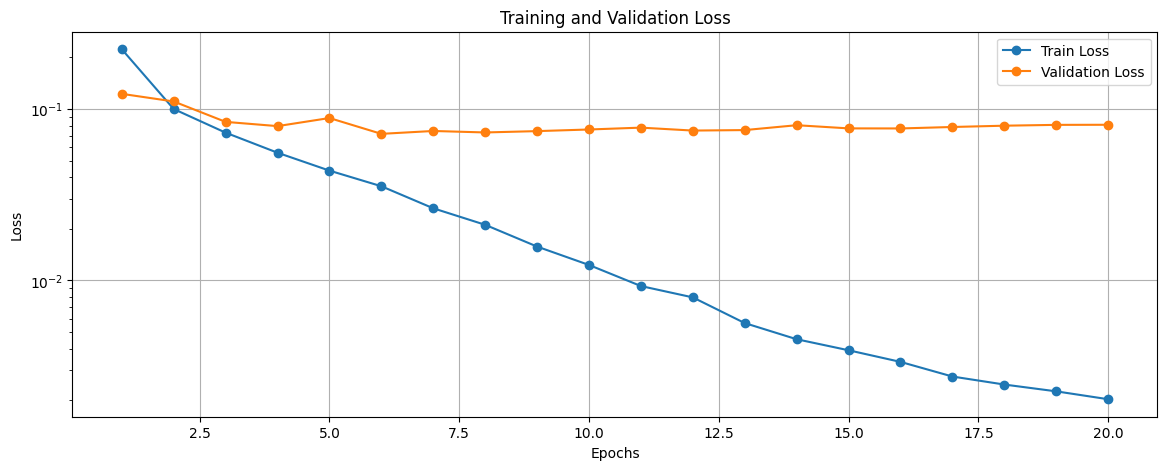

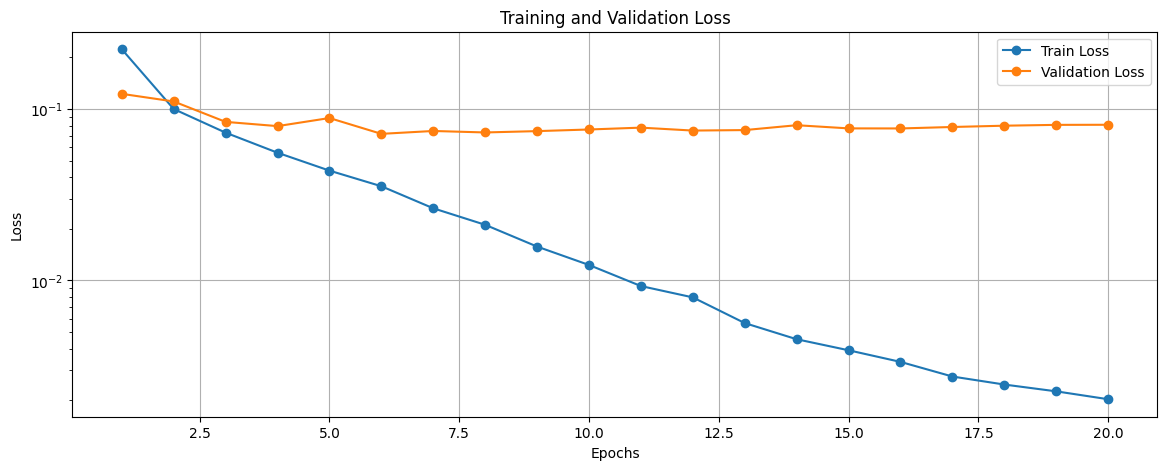

In [64]:
best_model, loss_validation = training_pipeline(epochs=20, model=model, train_loader=train_loader, test_loader=test_loader, optimizer=optimizer, patience=patience)

In [ ]:
log_prior_std_precision = 100.0
log_prior_std_base = 0.1
deltaPAC = 0.025

def compute_B(KL, log_prior_std, effective_m, log_prior_std_precision=100.0, log_prior_std_base= 0.1):
    """
    Computes the PAC-Bayes complexity term B.
    """

    factor1 = 2 * torch.log(log_prior_std_precision)
    factor2 = 2 * torch.log(torch.maximum(torch.log(log_prior_std_base) - 2 * log_prior_std, torch.tensor(1e-2)))

    Bquad = KL / 2 + torch.log(torch.tensor(np.pi**2 * effective_m / (6 * 0.05))) + factor1 + factor2

    c = Bquad / (2 * (effective_m - 1))
    B = torch.sqrt(c)

    return B

def pac_bayes_opt(w, w0, target,log_prior_std, effective_m, log_prior_std_precision=100.0, log_prior_std_base= 0.1, lr=0.01, epochs=100):
    """
    Optimizes the PAC-Bayes bound: Algorithm  1

    Parameters:
      w      : initial network weights (requires_grad=True)
      w0     : copy of initial weights to serve as prior (w0)

    Returns:
      Optimized parameters:
         w       : optimized weights
         s       : variance term computed as s = exp(2 * zeta)
         lam     : regularization parameter computed as lam = exp(2 * p)
    """

    # Initialize zeta and p
    zeta = torch.abs(w).clone().detach().requires_grad_(True)
    p = torch.tensor(-3.0, requires_grad=True)

    # Optimizer for all parameters: w, zeta, and p
    optimizer = torch.optim.RMSprop([w, zeta, p], lr=lr)

    for t in range(epochs):
        optimizer.zero_grad()

        s = torch.exp(2 * zeta)
        lam = torch.exp(2 * p)

        # Compute perturbed weights
        xi = torch.randn_like(w)
        w_pert = w + xi * torch.sqrt(s)

        # (?) 
        A = torch.mean((w_pert - target)**2)

        d = w.numel()

        factor1 = 2 * torch.log(log_prior_std_precision)
        factor2 = 2 * torch.log(torch.maximum(torch.log(log_prior_std_base) - 2 * log_prior_std, torch.tensor(1e-2)))

        Bquad = KL / 2 + torch.log(torch.tensor(np.pi**2 * effective_m / (6 * 0.05))) + factor1 + factor2

        c = Bquad / (2 * (effective_m - 1))
        B = torch.sqrt(c)
        
        KL = 0.5 * ( (torch.sum(torch.exp(2 * zeta)) + torch.sum((w - w0)**2)) / lam
                     - d + d * torch.log(lam) - 2 * torch.sum(zeta) )
        
        B = compute_B(KL, log_prior_std, effective_m, log_prior_std_precision=100.0, log_prior_std_base= 0.1) 
        
        obj = A + B

        obj.backward()
        optimizer.step()

        if t % 10 == 0:
            print(f"Iteration {t}: A = {A.item():.4f}, KL = {KL.item():.4f}, B = {B.item():.4f}, Obj = {obj.item():.4f}")
    
    return w, torch.exp(2 * zeta), torch.exp(2 * p)
